# EJERCICIO

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,  StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn import set_config
from sklearn.compose import ColumnTransformer , make_column_selector
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.metrics import accuracy_score
import joblib
import warnings
 

In [3]:
warnings.filterwarnings("ignore", category=FutureWarning)
set_config(display="diagram")

## DEFINICIÓN DEL PROBLEMA

**Vamos a trabajar con un dataframe sobre los datos del titanic que viene en la librería seaborn para intentar predecir si una persona sobrevivió o no a partir del resto de atributos.**

**Como criterio de evaluación vamos a usar la exactitud (accuracy), que mide la proporción de predicciones correctas realizadas por el modelo.**

## RECOPILACIÓN Y PREPARACIÓN DE LOS DATOS

### OBTENER LOS DATOS

In [4]:
df_titanic = sns.load_dataset('titanic')

En el conjunto de datos Titanic, cada columna proporciona información específica sobre los pasajeros del Titanic.

1. `survived`: Esta columna indica si un pasajero sobrevivió o no al naufragio del Titanic. Tiene dos valores posibles: 0 (no sobrevivió) y 1 (sobrevivió).

2. `pclass`: Representa la clase de pasaje del pasajero en el Titanic. Tiene tres valores posibles: 1 (primera clase), 2 (segunda clase) y 3 (tercera clase).

3. `sex`: Indica el género del pasajero, ya sea masculino o femenino.

4. `age`: Representa la edad del pasajero en años.

5. `sibsp`: Indica el número de hermanos o cónyuges que el pasajero tenía a bordo del Titanic.

6. `parch`: Representa el número de padres o hijos que el pasajero tenía a bordo del Titanic.

7. `fare`: Indica la tarifa que el pasajero pagó por su pasaje.

8. `embarked`: Representa el puerto de embarque del pasajero. Tiene tres valores posibles: "C" (Cherbourg), "Q" (Queenstown) y "S" (Southampton).

9. `class`: Similar a `pclass`, pero se expresa en palabras en lugar de números.

10. `who`: Indica si el pasajero es un niño (child), hombre (man) o mujer (woman).

11. `adult_male`: Indica si el pasajero es adulto y masculino.

12. `deck`: Representa la cubierta en la que se encontraba la cabina del pasajero (si es que se encontraba en cubierta).

13. `embark_town`: El nombre de la ciudad o localidad correspondiente al puerto de embarque.

14. `alive`: Indica si el pasajero está vivo o muerto. Similar a `survived`, pero se expresa como "yes" (sí) o "no" (no).

15. `alone`: Indica si el pasajero viajaba solo (True) o con compañía (False).

### EXPLORAR LOS DATOS

Muestra las primeras líneas del dataframe

In [5]:
df_titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


¿Cuántas columnas hay? ¿De que tipo? ¿Cuántos valores no nulos tiene cada columna?

In [6]:
df_titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


Elimina las columnas innecesarias:
- `class`: la información está también en pclass
- `who`: con sex y age se obtiene la información
- `adult_male`: con sex y age se obiene la información
- `deck`: tiene muchos valores nulos y es díficil decidir que valor dar a los valores ausentes
- `embark_town`: la información está también en embarked
- `alive`: la información está también en survived
- `alone`: con sibsp y parch se obtiene la información

In [7]:
df_titanic_dropped=df_titanic.drop(['class','who','adult_male','deck','embark_town','alive','alone'],axis=1)

df_titanic_dropped

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S
887,1,1,female,19.0,0,0,30.0000,S
888,0,3,female,NaN,1,2,23.4500,S
889,1,1,male,26.0,0,0,30.0000,C


Muestra las estadísticas básicas de los atributos numéricos

In [8]:
df_titanic_dropped.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Muestra las estadísticas descriptivas de los atributos categóricos (con el parametro include)

In [9]:
df_titanic_dropped.describe(include=["object"])

,sex,embarked
count,891,889
unique,2,3
top,male,S
freq,577,644


Respresenta los atributos en un histograma o diagrama de barras para ver sus distribuciones: 
- usa seaborn
- dibuja los ochos en un mismo grafico con 8 subgrafos (4x2)
- usa counplot de seaborn para las variables categoricas o discretas
- usa histplot de seaborn para las variables continuas

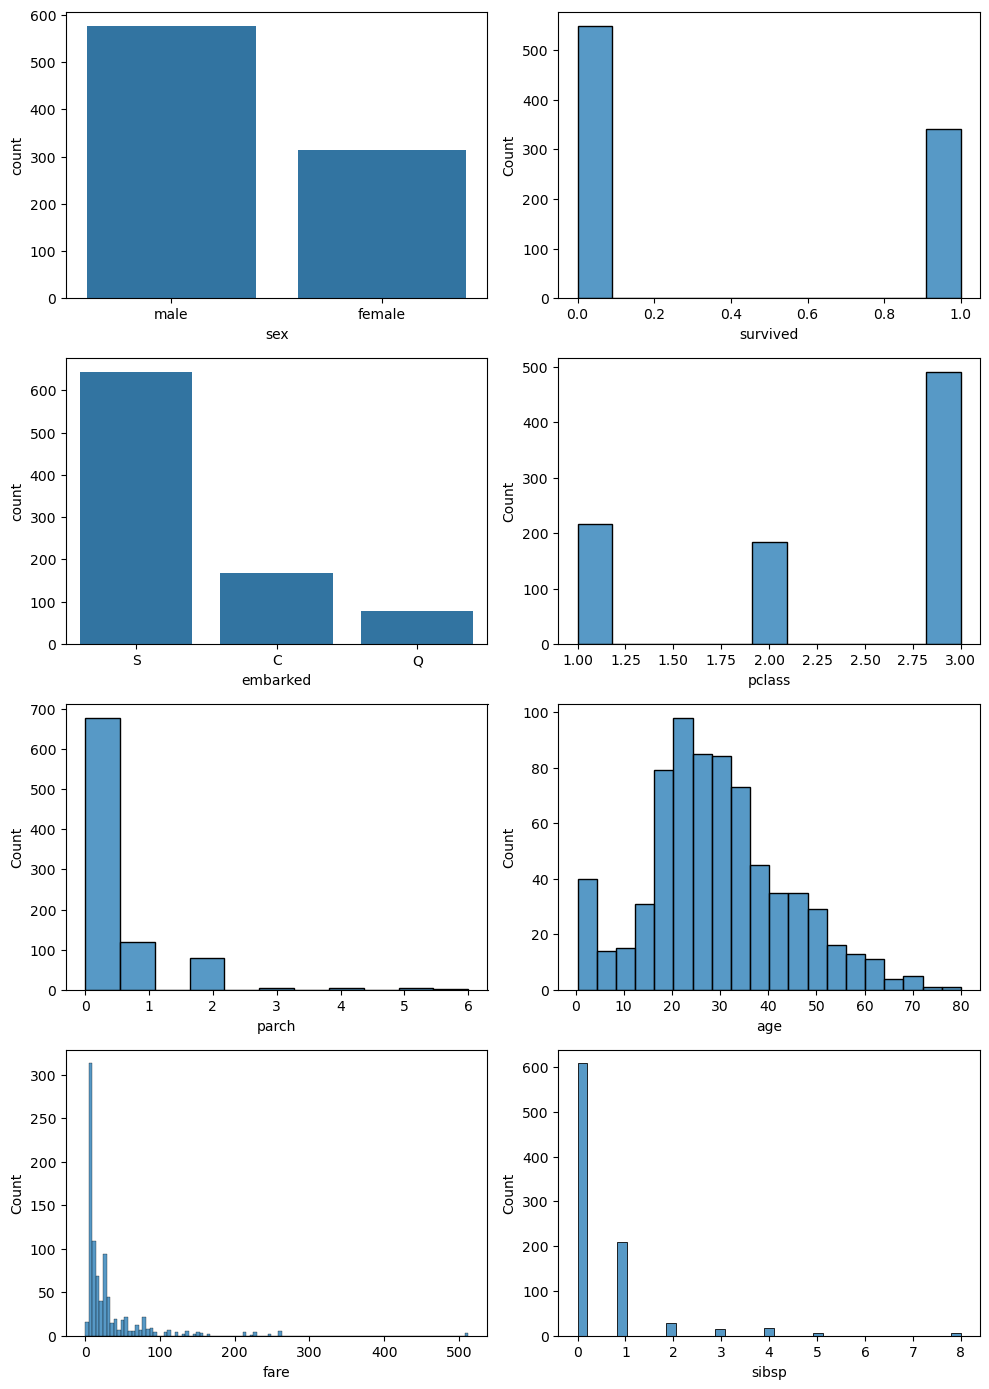

In [10]:
df_object = df_titanic_dropped.select_dtypes(include=["object"])
df_num = df_titanic_dropped.select_dtypes(include=[np.number])

# Crear figura con subplots
fig, axes = plt.subplots(4, 2, figsize=(10, 14))  # Ajustar tamaño de figura según convenga



for i, var in enumerate(df_object.columns):
    sns.countplot(x=var, data=df_titanic_dropped, ax=axes[i][0])

for i, var in enumerate(df_num.columns):
    if(i>3):
        if(i==4):
            sns.histplot(x=var, data=df_titanic_dropped, ax=axes[2][0])
        else:
            sns.histplot(x=var, data=df_titanic_dropped, ax=axes[3][0])
    else:
        sns.histplot(x=var, data=df_titanic_dropped, ax=axes[i][1])


# Ajustar el layout y mostrar el gráfico
plt.tight_layout()
plt.show()

¿A la vista de los datos que conclusiones puedes sacar?

Que embarcaron mas hombres que mujeres,que hubo mas muertos que supervivientes, 
que embarcaron la mayoria de Southampton, que la mayoria de los pasajeros eran de 3a clase,
la gran mayoria de las personas iban sin padres o hijos, la gran mayoria de las personas eran de entre 18-40 años,
casi todo el mundo pago un ticket barato y la gran mayoria de personas iban sin hermanos a bordo.

Muestra la media de supervivientes según el la clase de billete ordenada de forma descendente según el valor de dicha media (en forma de dataframe) y saca alguna conclusión.

In [11]:
# Calcular la media de supervivientes por clase de billete
media_supervivientes = df_titanic_dropped.groupby('pclass')['survived'].mean().reset_index()
media_supervivientes.columns=['Clase','Media supervivientes']
media_supervivientes=media_supervivientes.sort_values(by='Media supervivientes', ascending=False)
media_supervivientes


,Clase,Media supervivientes
0,1,0.629630
1,2,0.472826
2,3,0.242363


Como conclusión podemos sacar que la gente de mayor clase sobrevivio mas de media

Muestra la media de supervivientes según el sexo ordenada de forma descendente según el valor de dicha media (en forma de dataframe) y saca alguna conclusión.

In [12]:
media_sexo=df_titanic_dropped.groupby('sex')['survived'].mean().reset_index()
media_sexo.columns=['Sexo','Media supervivientes']
media_sexo

,Sexo,Media supervivientes
0,female,0.742038
1,male,0.188908


Podemos ver claramente que las mujeres sobrevivieron mas de 4 veces mas de media

Muestra la media de supervivientes según el número de hermanos y coyúnges ordenada de forma descendente según el valor de dicha media (en forma de dataframe) y saca alguna conclusión.

In [13]:
media_hermanos=df_titanic_dropped.groupby('sibsp')['survived'].mean().reset_index()
media_hermanos.columns=['Nº herm y con','Media supervivientes']
media_hermanos=media_hermanos.sort_values(by='Media supervivientes', ascending=False)
media_hermanos

,Nº herm y con,Media supervivientes
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


La gente que tenia 1 y 2 hermanos o cónyunges de media se salvaron mas de media

Muestra la media de supervivientes según el número de padres e hijos ordenada de forma descendente según el valor de dicha media (en forma de dataframe) y saca alguna conclusión.

In [14]:
media_padres=df_titanic_dropped.groupby('parch')['survived'].mean().reset_index()
media_padres.columns=['Nº padres e hijos','Media supervivientes']
media_padres=media_padres.sort_values(by='Media supervivientes', ascending=False)
media_padres

,Nº padres e hijos,Media supervivientes
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


Los que tenian 3,1 y 2 padres o hijos sobrevivieron mas de la mitad

Halla las correlaciones de los datos numéricos y muestra el coeficiente de correlacion de las diferentes variables respecto a la variable survived

In [15]:
corr_matrix = df_titanic_dropped.corr(numeric_only=True)
corr_matrix['survived'].sort_values(ascending=False)

survived    1.000000
fare        0.257307
parch       0.081629
sibsp      -0.035322
age        -0.077221
pclass     -0.338481
Name: survived, dtype: float64

Representa la matriz de correlaciones (representa directamente la matriz usando el stilo background_gradient)

In [16]:
corr_matrix.style.background_gradient()

,survived,pclass,age,sibsp,parch,fare
survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
sibsp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


¿Qué conclusiones sacas de la matriz de correlaciones?

Podemos ver que el campo más relacionado con survived es pclass y le sigue relativamente cerca fare, mientras que el resto de columnas no tienen practicamente nada de relacion con esta.

Vamos a seguir explorando los datos haciendo algún gráfico más:

- Grafico de barras para representar el número de supervivientes según la clase de billete y por sexos

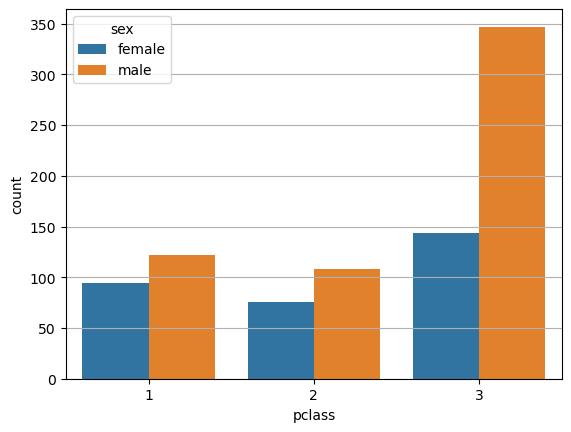

In [17]:
sns.countplot(data=df_titanic_dropped, x='pclass', hue='sex')
plt.grid(axis='y')
plt.show()

- Usando FaceGird de seaborn representa los supervivientes según la clase de billete y el puerto de embarque

/home/iabd/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


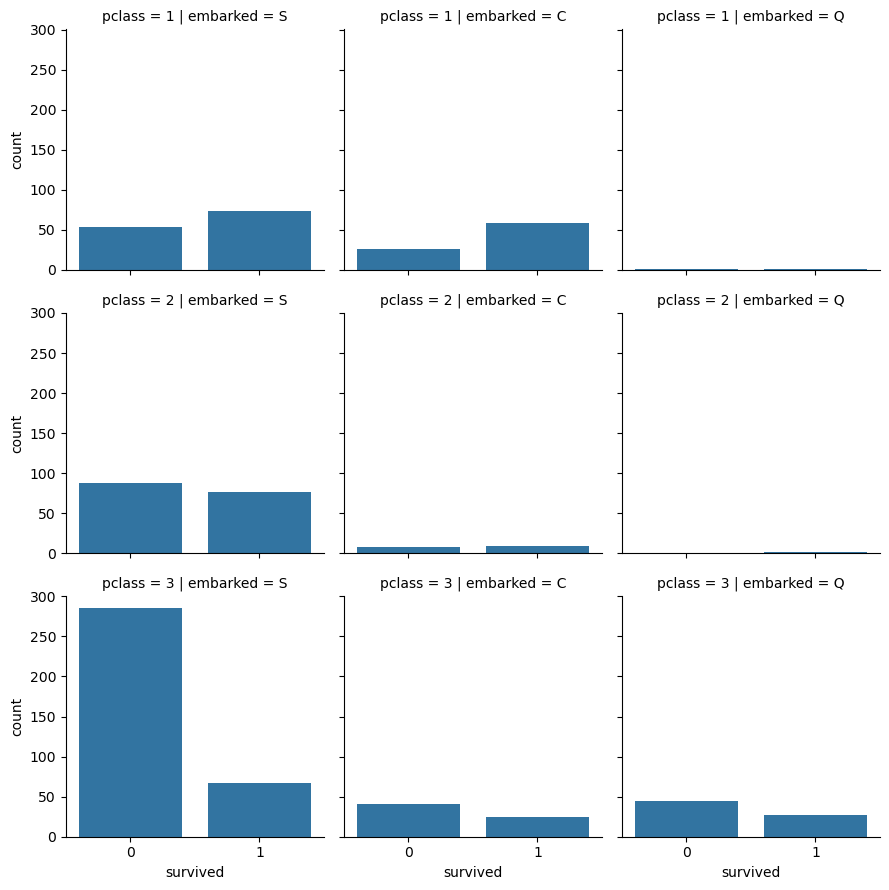

In [39]:
grid = sns.FacetGrid(df_titanic_dropped, col='embarked', row='pclass')
grid.map(sns.countplot,'survived')
plt.show()

### DIVIDIR LOS DATOS

Es hora de separar el conjunto de entrenamiento del conjunto de prueba (85% para el entrenamiento y haciendo un muestreo estratificado según la clase del billete, que parece que es una de las más correlacionada con la carracteristica survived y hay bastante más pasajeros de clase 3 que de clase 1 y2).

In [19]:
strat_train_set, strat_test_set = train_test_split(df_titanic_dropped, test_size=0.15, stratify=df_titanic_dropped['pclass'], random_state=42)
strat_test_set["pclass"].value_counts() / len(strat_test_set)


pclass
3    0.552239
1    0.238806
2    0.208955
Name: count, dtype: float64

In [20]:
strat_train_set["pclass"].value_counts() / len(strat_train_set)

pclass
3    0.550859
1    0.243065
2    0.206077
Name: count, dtype: float64

Haz una copia del conjunto de entrenamiento para trabajar con él.

In [21]:
df_titanic = strat_train_set.copy()
df_titanic1 = strat_train_set.copy()
df_titanic

,survived,pclass,sex,age,sibsp,parch,fare,embarked
63,0,3,male,4.0,3,2,27.9000,S
465,0,3,male,38.0,0,0,7.0500,S
320,0,3,male,22.0,0,0,7.2500,S
56,1,2,female,21.0,0,0,10.5000,S
348,1,3,male,3.0,1,1,15.9000,S
...,...,...,...,...,...,...,...,...
448,1,3,female,5.0,2,1,19.2583,C
789,0,1,male,46.0,0,0,79.2000,C
229,0,3,female,NaN,3,1,25.4667,S
625,0,1,male,61.0,0,0,32.3208,S


### PREPARAR LOS DATOS

Hay que crear un pipeline de transformación que haga los siguientes cambios:
- pclass: 
  - rellenar datos faltantes con la moda
- sex:
  - rellenar datos faltantes con la moda
  - convertir male a 0 y female a 1
- age:
  - rellenar datos faltantes con la media
  - convertirla en variable categórica:
      - 1 - <=16
      - 2 - (16,32]
      - 3 - (32,48]
      - 4 - (48,64]
      - 5 - >64)
- family = sibsp + parch
  - rellenar datos faltantes con la moda
  - sumar las dos columnas
- fare
  - rellenar datos faltantes con la media
  - aplicar raiz cuadrada
  - estandarizar
- embarked
  - rellenar datos faltantes con la moda
  - aplicar one-hot

Pero vamos a empezar poco a poco

Crea el atributo familia como suma de sibsp y parch y luego borra sibsp y parch

In [22]:
df_titanic['familia']=df_titanic['sibsp']+df_titanic['parch']
df_titanic_fam=df_titanic.drop(columns=['sibsp','parch'])
df_titanic_fam

,survived,pclass,sex,age,fare,embarked,familia
63,0,3,male,4.0,27.9000,S,5
465,0,3,male,38.0,7.0500,S,0
320,0,3,male,22.0,7.2500,S,0
56,1,2,female,21.0,10.5000,S,0
348,1,3,male,3.0,15.9000,S,2
...,...,...,...,...,...,...,...
448,1,3,female,5.0,19.2583,C,3
789,0,1,male,46.0,79.2000,C,0
229,0,3,female,NaN,25.4667,S,4
625,0,1,male,61.0,32.3208,S,0


Rellenamos los datos ausentes en el dataframe (lo hacemos para todas las columnas aunque ahora la mayoría no tiene datos ausentes, pero no sabemos como serán los datos si tenemos que volver a entrenar el modelo)

In [23]:
col_obj=df_titanic_fam.select_dtypes(include=["object"])

for col in col_obj:
    df_titanic_fam[col].fillna(df_titanic_fam[col].mode()[0], inplace=True)

col_num=df_titanic_fam.select_dtypes(include=['int64','float64'])

for col in col_num:
    df_titanic_fam[col].fillna(df_titanic_fam[col].mean(),inplace=True)

print(df_titanic_fam.isnull().sum())


survived    0
pclass      0
sex         0
age         0
fare        0
embarked    0
familia     0
dtype: int64


En el columna sex sustituir male por 0 y female por 1

In [24]:
df_titanic_fam['sex'] = df_titanic_fam['sex'].replace({'male': 0, 'female': 1})
df_titanic_fam.head()

,survived,pclass,sex,age,fare,embarked,familia
63,0,3,0,4.0,27.90,S,5
465,0,3,0,38.0,7.05,S,0
320,0,3,0,22.0,7.25,S,0
56,1,2,1,21.0,10.50,S,0
348,1,3,0,3.0,15.90,S,2


Aplicar One-Hot a la columna embarked

In [25]:
cat_encoder = OneHotEncoder()

embarked_cat=df_titanic_fam[['embarked']]

embarked_cat_enc=cat_encoder.fit_transform(embarked_cat)

df_embarked=pd.DataFrame(cat_encoder.transform(embarked_cat).toarray(),
                         columns=cat_encoder.get_feature_names_out(),
                         index=embarked_cat.index)
df_titanic_fam = pd.concat([df_titanic_fam, df_embarked], axis=1)
df_titanic_emb=df_titanic_fam.drop(columns='embarked')
df_titanic_emb

,survived,pclass,sex,age,fare,familia,embarked_C,embarked_Q,embarked_S
63,0,3,0,4.000000,27.9000,5,0.0,0.0,1.0
465,0,3,0,38.000000,7.0500,0,0.0,0.0,1.0
320,0,3,0,22.000000,7.2500,0,0.0,0.0,1.0
56,1,2,1,21.000000,10.5000,0,0.0,0.0,1.0
348,1,3,0,3.000000,15.9000,2,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
448,1,3,1,5.000000,19.2583,3,1.0,0.0,0.0
789,0,1,0,46.000000,79.2000,0,1.0,0.0,0.0
229,0,3,1,29.568966,25.4667,4,0.0,0.0,1.0
625,0,1,0,61.000000,32.3208,0,0.0,0.0,1.0


Convertir la variable age en una variable categórica: 
- 1 - <=16
- 2 - (16,32]
- 3 - (32,48]
- 4 - (48,64]
- 5 - >64)

In [26]:
df_titanic_emb['age_cat']=pd.cut(df_titanic_emb['age'], bins=[-1,16,32,48,64,float('inf')], labels=[1,2,3,4,5])
df_titanic_age=df_titanic_emb.drop(columns='age')
df_titanic_age

,survived,pclass,sex,fare,familia,embarked_C,embarked_Q,embarked_S,age_cat
63,0,3,0,27.9000,5,0.0,0.0,1.0,1
465,0,3,0,7.0500,0,0.0,0.0,1.0,3
320,0,3,0,7.2500,0,0.0,0.0,1.0,2
56,1,2,1,10.5000,0,0.0,0.0,1.0,2
348,1,3,0,15.9000,2,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...
448,1,3,1,19.2583,3,1.0,0.0,0.0,1
789,0,1,0,79.2000,0,1.0,0.0,0.0,3
229,0,3,1,25.4667,4,0.0,0.0,1.0,2
625,0,1,0,32.3208,0,0.0,0.0,1.0,4


Como la columna fare tiene una cola larga por la derecha y tiene valores que son cero aplica la raiz cuadrada a la variable

In [27]:
df_titanic_age['fare_sqrt'] = np.sqrt(df_titanic_fam['fare'])
df_titanic_fare=df_titanic_age.drop(columns='fare')
df_titanic_fare

,survived,pclass,sex,familia,embarked_C,embarked_Q,embarked_S,age_cat,fare_sqrt
63,0,3,0,5,0.0,0.0,1.0,1,5.282045
465,0,3,0,0,0.0,0.0,1.0,3,2.655184
320,0,3,0,0,0.0,0.0,1.0,2,2.692582
56,1,2,1,0,0.0,0.0,1.0,2,3.240370
348,1,3,0,2,0.0,0.0,1.0,1,3.987480
...,...,...,...,...,...,...,...,...,...
448,1,3,1,3,1.0,0.0,0.0,1,4.388428
789,0,1,0,0,1.0,0.0,0.0,3,8.899438
229,0,3,1,4,0.0,0.0,1.0,2,5.046454
625,0,1,0,0,0.0,0.0,1.0,4,5.685139


Estandarizar la variable fare

In [28]:
std_scaler = StandardScaler()
df_titanic_fare['fare_standardized'] = std_scaler.fit_transform(df_titanic_fare[['fare_sqrt']])
df_titanic_fare_sta=df_titanic_fare.drop(columns='fare_sqrt')
df_titanic_fare_sta

,survived,pclass,sex,familia,embarked_C,embarked_Q,embarked_S,age_cat,fare_standardized
63,0,3,0,5,0.0,0.0,1.0,1,0.151298
465,0,3,0,0,0.0,0.0,1.0,3,-0.734305
320,0,3,0,0,0.0,0.0,1.0,2,-0.721696
56,1,2,1,0,0.0,0.0,1.0,2,-0.537019
348,1,3,0,2,0.0,0.0,1.0,1,-0.285143
...,...,...,...,...,...,...,...,...,...
448,1,3,1,3,1.0,0.0,0.0,1,-0.149970
789,0,1,0,0,1.0,0.0,0.0,3,1.370842
229,0,3,1,4,0.0,0.0,1.0,2,0.071872
625,0,1,0,0,0.0,0.0,1.0,4,0.287194


Ya esta el dataframe con los datos de entrenamiento preparados, pero los cambios hechos también hay que hacerlos en los datps de prueba a y en un futuro en otros dataframe bien para entrenar de nuevo el modelo, bien para predecir datos. Por lo tanto, hay que crear una pipeline a la que le pasamos el dataframe y haga todos los cambios.

In [29]:
def column_family(X):
    return X[:, [0]] + X[:, [1]]

def family_name(function_transformer, feature_names_in):
    return ["family"] 

def family_pipeline():
    return make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    FunctionTransformer(column_family, feature_names_out=family_name))

def encode_sex(X):
    X[:, 0] = np.where(X[:, 0] == 'male', 0, 1) 
    return X

def categorize_age(X):
    bins = [-1, 16, 32, 48, 64, 100]
    labels = [1, 2, 3, 4, 5]

    categorized_age = np.zeros(X.shape[0], dtype=int)

    for i in range(X.shape[0]):
        age = X[i, 0] 
        if age <= bins[1]:
            categorized_age[i] = labels[0]
        elif age <= bins[2]:
            categorized_age[i] = labels[1]  
        elif age <= bins[3]:
            categorized_age[i] = labels[2]
        elif age <= bins[4]:
            categorized_age[i] = labels[3]
        else:
            categorized_age[i] = labels[4]    
    return categorized_age.reshape(-1, 1)

pclass_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"))

sex_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    FunctionTransformer(encode_sex, feature_names_out="one-to-one"))

age_pipeline = make_pipeline(
    SimpleImputer(strategy="mean"),
    FunctionTransformer(categorize_age, feature_names_out="one-to-one")
)

fare_pipeline = make_pipeline(
    SimpleImputer(strategy="mean"),
    FunctionTransformer(np.sqrt,feature_names_out="one-to-one"),
    StandardScaler())

embarked_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder())

preprocessing = ColumnTransformer([
    ("family",family_pipeline(),["parch","sibsp"]),
    ("pclass_transform", pclass_pipeline, ["pclass"]),
    ("sex_transform", sex_pipeline, ["sex"]),
    ("age_transform", age_pipeline, ["age"]),
    ("fare_transform", fare_pipeline, ["fare"]),
    ("embarked_transform", embarked_pipeline, ["embarked"])
] ,remainder='passthrough')

df_transformed = preprocessing.fit_transform(df_titanic1)
print(df_transformed)
df_transformed.shape

[[5 3 0 ... 0.0 1.0 0]
 [0 3 0 ... 0.0 1.0 0]
 [0 3 0 ... 0.0 1.0 0]
 ...
 [4 3 1 ... 0.0 1.0 0]
 [0 1 0 ... 0.0 1.0 0]
 [2 2 1 ... 0.0 1.0 1]]


(757, 9)

In [30]:
preprocessing.get_feature_names_out()

array(['family__family', 'pclass_transform__pclass', 'sex_transform__sex',
       'age_transform__age', 'fare_transform__fare',
       'embarked_transform__embarked_C', 'embarked_transform__embarked_Q',
       'embarked_transform__embarked_S', 'remainder__survived'],
      dtype=object)

## ENTRENAMIENTO Y EVALUACIÓN DEL MODELO

Vamos a probar varios algoritmos para ver cual es el que mejor va, para ello primero vamos a evaluarlos manualmente y luego ya utilizaremos validación cruzada.

En concreto vamos a probar:
- Regresión logística
- Random Forest
- KNN (K - Nearest Neighbors)

Cuanto más se acerque a 1 la exactitud (accuracy), mejor será el modelo.

### REGRESIÓN LOGÍSTICA
Pasos a seguir:
- Separar y (columna a predecir) y X (resto de columnas) en el conjunto de entrenamiento
- Separar y (columna a predecir) y X (resto de columnas) en el conjunto de test
- Crear el modelo (modelo = LogisticRegression())
- Entrenar el modelo
- Calcular la precisión para el conjunto de entrenamiento (usa accuracy_score)
- Calcular la precisión para el conjunto de test 

In [31]:
# Separamos columnas
x_train= strat_train_set.drop(columns=["survived"])
y_train= strat_train_set["survived"].copy()

x_test= strat_test_set.drop(columns=["survived"])
y_test= strat_test_set["survived"].copy()

# Crear el pipeline que incluye preprocesamiento y modelo
lin_reg = make_pipeline(preprocessing, LogisticRegression())

# Entrenamos
lin_reg.fit(x_train, y_train)

train_predictions = accuracy_score( y_train, lin_reg.predict(x_train))
test_predictions = lin_reg.score(x_test, y_test)
print(train_predictions)
print(test_predictions)



0.8031704095112285
0.7611940298507462


### RANDOM FOREST
Hacemos lo mismo pero ahora usando el algoritmo Random Forest (RandomForestClassifier(n_estimators=100))

In [32]:
rand_tree_reg = make_pipeline(preprocessing, RandomForestClassifier(n_estimators=100))
rand_tree_reg.fit(x_train, y_train)

train_predictionsRF = accuracy_score( y_train, rand_tree_reg.predict(x_train))
test_predictionsRF = rand_tree_reg.score(x_test,y_test)
print(train_predictionsRF)
print(test_predictionsRF)



0.9431968295904888
0.7835820895522388


### K - NEAREST NEIGHBORS
Hacemos lo mismo pero ahora usando el algoritmo K - Nearest Neighbours (KNeighborsClassifier(n_neighbors=3))

In [33]:
k_near = make_pipeline(preprocessing, KNeighborsClassifier(n_neighbors=3))
k_near.fit(x_train, y_train)

train_predictionsKN = accuracy_score( y_train, k_near.predict(x_train))
test_predictionsKN = k_near.score(x_test,y_test)
print(train_predictionsKN)
print(test_predictionsKN)


0.8863936591809776
0.7164179104477612


### COMPARACIÓN

Muestra una tablas con los resultado obtenidos


| Modelo                 |Precisión entrenamiento   | Precisión test    |
|------------------------|--------------------------|-------------------|
| LogisticRegression     |0.8031704095112285        |0.7611940298507462 |
| RandomForestClassifier |0.9431968295904888        |0.7761194029850746 |
| KNeighborsClassifier   |0.8863936591809776        |0.7164179104477612 |

A la vista de los resultados con ¿cual te quedas para trabajarlo con validación cruzada y luego optimizarlo?

Nos vamos a quedar con Random Forest ya que nos da los mejores resultados en ambos casos, aunque en el precision test el LogisticRegresion esta muy cerca del anterior algoritmo.

Vamos a usar RandomForestClassifier con validación cruzada

In [34]:
rand_tree_rmses = -cross_val_score(rand_tree_reg, x_train, y_train, scoring="neg_root_mean_squared_error", cv=100)
pd.Series(rand_tree_rmses).describe()

count    100.000000
mean       0.390554
std        0.188418
min        0.000000
25%        0.353553
50%        0.377964
75%        0.500000
max        0.790569
dtype: float64

## OPTIMIZACIÓN DEL MODELO

Vamos a optimizar el modelo usando busqueda aleatorio para optimizar los hiperparametros, en concreto vamos a mejorar los siguientes hiperparametros
``````
param_dist = {
    'randomforestclassifier__n_estimators': randint(10, 200),
    'randomforestclassifier__max_features': ['sqrt', 'log2', None]
}
``````

In [35]:
param_dist = {
    'randomforestclassifier__n_estimators': randint(10, 200),
    'randomforestclassifier__max_features': ['sqrt', 'log2', None]
}

full_pipeline = make_pipeline(
    preprocessing,  
    RandomForestClassifier(random_state=42)  
)

rnd_search = RandomizedSearchCV(
    full_pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=3
)

rnd_search.fit(x_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('family',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out=<function family_name at 0x7f1b6a5565c0>,
                                                                                                                    func=<function column_family at 0x7f1b6a554...
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehotencoder',
                                                                                                OneHotEncoder())]),
                                                                               ['embarked'])])),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'randomforestclassifier__max_features': ['sqrt',
                                                                                 'log2',
                                                                                 None],
                                        'randomforestclassifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f1b6a56aa20>})

In [36]:
cv_res = pd.DataFrame(rnd_search.cv_results_)
cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_features,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.048545,0.003108,0.010761,0.000408,None,18,"{'randomforestclassifier__max_features': None,...",0.830040,0.797619,0.769841,0.799167,0.024600,10
1,0.208450,0.010406,0.019482,0.001839,None,126,"{'randomforestclassifier__max_features': None,...",0.841897,0.817460,0.801587,0.820315,0.016580,3
2,0.074567,0.015220,0.012424,0.000571,sqrt,33,{'randomforestclassifier__max_features': 'sqrt...,0.822134,0.829365,0.809524,0.820341,0.008199,2
3,0.156814,0.010081,0.016994,0.000837,sqrt,108,{'randomforestclassifier__max_features': 'sqrt...,0.830040,0.821429,0.797619,0.816362,0.013712,6
4,0.064166,0.000574,0.011314,0.001291,sqrt,36,{'randomforestclassifier__max_features': 'sqrt...,0.826087,0.821429,0.793651,0.813722,0.014319,8
5,0.155409,0.006513,0.015786,0.001076,None,93,"{'randomforestclassifier__max_features': None,...",0.849802,0.813492,0.801587,0.821627,0.020507,1
6,0.122689,0.000391,0.015747,0.000957,log2,82,{'randomforestclassifier__max_features': 'log2...,0.830040,0.813492,0.793651,0.812394,0.014876,9
7,0.077451,0.000572,0.012553,0.000715,log2,43,{'randomforestclassifier__max_features': 'log2...,0.830040,0.821429,0.801587,0.817685,0.011913,4
8,0.223810,0.003520,0.019751,0.000832,sqrt,168,{'randomforestclassifier__max_features': 'sqrt...,0.830040,0.821429,0.801587,0.817685,0.011913,4
9,0.068978,0.000285,0.012093,0.000085,log2,40,{'randomforestclassifier__max_features': 'log2...,0.826087,0.825397,0.793651,0.815045,0.015131,7


### EVALUACIÓN EN EL CONJUNTO DE PRUEBA

EvaluaR el modelo usando accuracy_score y el conjunto de datos de test

In [37]:
final_model = rnd_search.best_estimator_  
test_prediction_final = accuracy_score( y_test, final_model.predict(x_test))

print(test_prediction_final)


0.7910447761194029


## PRESENTACIÓN DE LA SOLUCIÓN

Ahora tienes que crear un archivo .py con todo lo necesario para que ejecute el modelo que acabamos de crear, en concreto el script tiene que ejecutar lo siguiente:
- Pedir un csv para predecir los datos (suponemos que los datos en el csv están bien)
- Cargamos los datos del csv en un dataframe.
- Aplicamos nuestro modelo al dataframe.
- Informamos al usuario de las predicciones.

In [38]:
joblib.dump(final_model, "modeloTitanic.pkl")


['modeloTitanic.pkl']